In [2]:
import os
import rasterio
from pathlib import Path
import geopandas as geopd
import pandas as pd
import numpy as np
from rasterio import features as r_feat
from rasterio import plot as r_plot
import shutil

os.chdir('/home/me/workspace/det_remota/trabalho_final')


RIPARIAN_ZONAL_STATS_PATH = Path('data/qgis_outputs/dzetsaka_models/predicted_rasters/riparian_zonal_stats')

BAND_STATS_COLUMNS = [
    f'band{idx}_{stat_name}'
    for idx in range(7, 11)
    for stat_name in ['count', 'sum', 'mean', 'median', 'stdev', 'min', 'max']
]

SOURCE_GDFS_PATHS = RIPARIAN_ZONAL_STATS_PATH.glob('*.gpkg') 
SOURCE_GDFS = []
for src_path in SOURCE_GDFS_PATHS:
    year = str(src_path).split('/')[-1].split('_')[-1].replace('.gpkg', '')
    gdf = geopd.read_file(src_path)
    gdf['year'] = year
    gdf['area_id'] = [f"{year}_{idx+1}"for idx in range(gdf.shape[0])]
    SOURCE_GDFS.append(gdf)



zonal_stats_gdf = pd.concat(SOURCE_GDFS)
zonal_stats_gdf = zonal_stats_gdf.loc[:, ['year', 'area_id'] + BAND_STATS_COLUMNS + ['geometry']]
zonal_stats_gdf

,year,area_id,band7_count,band7_sum,band7_mean,band7_median,band7_stdev,band7_min,band7_max,band8_count,...,band9_min,band9_max,band10_count,band10_sum,band10_mean,band10_median,band10_stdev,band10_min,band10_max,geometry
0,2023,2023_1,4731.000000,498063.000000,105.276474,86.0,76.874097,0.0,255.0,4731.000000,...,0.0,217.0,4731.000000,425722.000000,89.985627,69.0,83.351785,0.0,255.0,"POLYGON ((-7062049.17 -1120794.428, -7062047.1..."
1,2023,2023_2,848.000000,34890.000000,41.143868,39.0,21.927853,0.0,135.0,848.000000,...,0.0,205.0,848.000000,64570.000000,76.143868,73.0,36.578045,0.0,233.0,"POLYGON ((-7065025.849 -1120740.949, -7064992...."
2,2023,2023_3,837.000000,27986.000000,33.436081,11.0,54.534369,0.0,220.0,837.000000,...,0.0,0.0,837.000000,37149.000000,44.383513,17.0,56.023121,1.0,225.0,"POLYGON ((-7081181.313 -1120313.757, -7081139...."
3,2023,2023_4,840.000000,30168.000000,35.914286,20.0,37.265806,0.0,174.0,840.000000,...,0.0,39.0,840.000000,17637.000000,20.996429,14.0,20.788074,0.0,135.0,"POLYGON ((-7079268.67 -1119811.382, -7079261.3..."
4,2023,2023_5,857.000000,45759.000000,53.394399,40.0,37.222637,6.0,230.0,857.000000,...,0.0,15.0,857.000000,48438.000000,56.520420,49.0,32.584866,0.0,228.0,"POLYGON ((-7077287.421 -1119624.764, -7077245...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2024,2024_1142,197.000000,12415.000000,63.020305,50.0,53.379682,0.0,230.0,197.000000,...,0.0,20.0,197.000000,13744.000000,69.766497,54.0,62.023381,0.0,228.0,"POLYGON ((-6949344.002 -1115948.529, -6949342...."
1142,2024,2024_1143,192.000000,40855.000000,212.786458,247.0,53.159854,56.0,255.0,192.000000,...,0.0,76.0,192.000000,39.000000,0.203125,0.0,1.313151,0.0,11.0,"POLYGON ((-6948873.76 -1115913.683, -6948887.6..."
1143,2024,2024_1144,18.000000,342.000000,19.000000,14.0,16.822604,0.0,68.0,18.000000,...,0.0,0.0,18.000000,96.000000,5.333333,0.0,7.972174,0.0,23.0,"POLYGON ((-6948653.593 -1115561.905, -6948660...."
1144,2024,2024_1145,0.483861,14.300143,29.554227,30.0,5.528130,20.0,30.0,0.483861,...,0.0,0.0,0.483861,31.935194,66.000737,54.0,21.871338,20.0,70.0,"POLYGON ((-6948241.894 -1112593.757, -6948239...."


In [6]:
melted_gdf = zonal_stats_gdf.melt(
    id_vars=['area_id', 'year', 'geometry'],
    value_vars=BAND_STATS_COLUMNS,
    var_name="stat_column",
    value_name="stat_value"
)

def rename_band(band_name):
    match band_name:
        case 'band7': 
            return 'NDMI'
        case 'band8': 
            return 'MSAVI2'
        case 'band9': 
            return 'NDWI'
        case 'band10': 
            return 'NDVI'
    return None

melted_gdf['band'] = melted_gdf.stat_column.apply(lambda x: rename_band(x.split('_')[0]))
melted_gdf['stat_name'] = melted_gdf.stat_column.apply(lambda x: x.split('_')[1])

melted_gdf = melted_gdf.pivot(
    index=['area_id', 'year', 'band', 'geometry'],
    columns=['stat_name'],
    values='stat_value'
).reset_index()
melted_gdf = melted_gdf.loc[melted_gdf.band != 'NDWI']
melted_gdf

stat_name,area_id,year,band,geometry,count,max,mean,median,min,stdev,sum
0,2017_1,2017,MSAVI2,"POLYGON ((-7061786.356 -1120969.536, -7061793....",830.0,255.0,36.592771,16.0,0.0,47.848334,30372.0
1,2017_1,2017,NDMI,"POLYGON ((-7061786.356 -1120969.536, -7061793....",830.0,170.0,70.020482,68.0,12.0,34.160794,58117.0
2,2017_1,2017,NDVI,"POLYGON ((-7061786.356 -1120969.536, -7061793....",830.0,228.0,37.187952,19.0,0.0,45.468521,30866.0
4,2017_10,2017,MSAVI2,"POLYGON ((-7073754.992 -1118214.498, -7073796....",1903.0,255.0,99.613242,74.0,0.0,76.154907,189564.0
5,2017_10,2017,NDMI,"POLYGON ((-7073754.992 -1118214.498, -7073796....",1903.0,255.0,84.477667,49.0,0.0,77.334934,160761.0
...,...,...,...,...,...,...,...,...,...,...,...
33353,2024_998,2024,NDMI,"POLYGON ((-6964769.613 -1111389.262, -6964748....",1143.0,242.0,67.641295,15.0,0.0,87.515453,77314.0
33354,2024_998,2024,NDVI,"POLYGON ((-6964769.613 -1111389.262, -6964748....",1143.0,228.0,51.258968,13.0,0.0,70.424431,58589.0
33356,2024_999,2024,MSAVI2,"POLYGON ((-6959198.238 -1110443.402, -6959193....",3923.0,255.0,42.231710,32.0,0.0,34.683663,165675.0
33357,2024_999,2024,NDMI,"POLYGON ((-6959198.238 -1110443.402, -6959193....",3923.0,220.0,36.774152,28.0,0.0,31.631311,144265.0


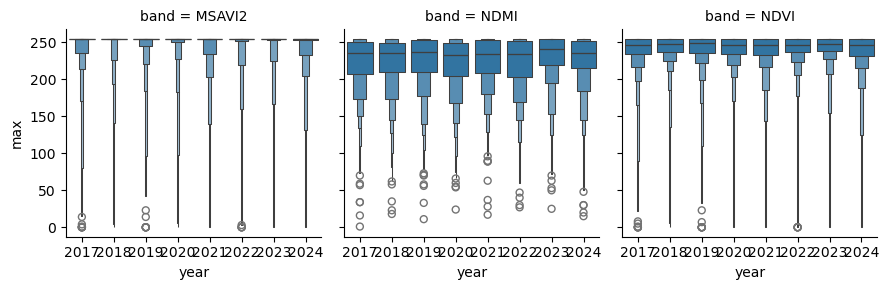

In [8]:
import seaborn as sns

sns.FacetGrid(melted_gdf, col='band')\
    .map_dataframe(sns.boxenplot, x='year', y='max')